# Install and import necessary site-packages

In [27]:
# ! pip install numpy scipy torch matplotlib
import logging
import math
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Type, Tuple, List, Dict, Union, Any
import copy
import operator
from enum import Enum, auto
from pathlib import Path
import matplotlib.pyplot as plt


# Define some help function

Define ***Sparse Dropout*** function and ***transform_matrix_2_Tensor*** function to accelerate computation

In [28]:
# Define dropout operation for Sparse Tensor to mitigate overfit quickly.
class SparseDropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, input):
        input_coal = input.coalesce() # transfer input tensor to COO format.
        drop_val = F.dropout(input_coal._values(), self.p, self.training) # only effect the value part _values() of sparse tensor.
        return torch.sparse.FloatTensor(input_coal._indices(), drop_val, input.shape) # reset sparse tensor.

# Mix dropout operation for Sparse Tensor and Dense Tensor.
class MixedDropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.dense_dropout = nn.Dropout(p) # standard dropout is okay.
        self.sparse_dropout = SparseDropout(p)

    def forward(self, input):
        if input.is_sparse:
            return self.sparse_dropout(input)
        else:
            return self.dense_dropout(input)


class MixedLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features)) # Random initialization. [in_features x out_features]
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    # Initialize weights and bias.
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, mode='fan_out', a=math.sqrt(5)) # Using Kaiming Uniform.
        if self.bias is not None:
            _, fan_out = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_out)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.bias is None:
            if input.is_sparse: # using sparse matrix multiplication.
                res = torch.sparse.mm(input, self.weight)
            else: # using standard matrix multiplication.
                res = input.matmul(self.weight)
        else:
            if input.is_sparse: # using sparse matrix multiplication.
                res = torch.sparse.addmm(self.bias.expand(input.shape[0], -1), input, self.weight)
            else: # using standard matrix multiplication.
                res = torch.addmm(self.bias, input, self.weight)
        return res

# tansform the sparse matrix to a PyTorch Tensor quickly.
def sparse_matrix_to_torch(X):
    coo = X.tocoo()
    indices = np.array([coo.row, coo.col])
    return torch.sparse.FloatTensor(
            torch.LongTensor(indices),
            torch.FloatTensor(coo.data),
            coo.shape)

# tansform the sparse matrix to a PyTorch Tensor.
def matrix_to_torch(X):
    if sp.issparse(X):
        return sparse_matrix_to_torch(X)
    else:
        return torch.FloatTensor(X)

# Compute PPR(Personalized PageRank) Matrix with teleport

In [29]:
# computes a normalized adjacency matrix with added self-loops.
def calc_A_hat(adj_matrix: sp.spmatrix | sp.sparray) -> sp.spmatrix | sp.sparray:
    nnodes = adj_matrix.shape[0]
    A = adj_matrix + sp.eye(nnodes) # add self-loops.
    D_vec = np.sum(A, axis=1) # degrees of each nodes.
    if isinstance(A, sp.spmatrix):
        D_vec = D_vec.A1
    D_vec_invsqrt_corr = 1 / np.sqrt(D_vec)
    D_invsqrt_corr = sp.diags(D_vec_invsqrt_corr) # D^{-1/2}
    return D_invsqrt_corr @ A @ D_invsqrt_corr # A^{hat} = D^{-1/2} A' D^{1/2}

# compute PPR(Personalized PageRank) Matrix exactly
def calc_ppr_exact(adj_matrix: sp.spmatrix, alpha: float) -> np.ndarray:
    nnodes = adj_matrix.shape[0]
    M = calc_A_hat(adj_matrix) # A^{hat}
    A_inner = sp.eye(nnodes) - (1 - alpha) * M # (I - (1 - \alpha) * A^{hat})^{-1}, where \alpha is teleportation probability
    return alpha * np.linalg.inv(A_inner.toarray()) # PPR = \alpha * ((I - (1 - \alpha) * A^{hat})^{-1})


class PPRExact(nn.Module):
    def __init__(self, adj_matrix: sp.spmatrix, alpha: float, drop_prob: float = None):
        super().__init__()

        ppr_mat = calc_ppr_exact(adj_matrix, alpha) # Compute PPR Matrix exactly.
        self.register_buffer('mat', torch.FloatTensor(ppr_mat)) # register in buffer, and transfer it to a Tensor
                                         # which is saved with model, but is not participating in backpropagation.
        # Using dropout if necessary.
        if drop_prob is None or drop_prob == 0:
            self.dropout = lambda x: x
        else:
            self.dropout = MixedDropout(drop_prob)

    def forward(self, predictions: torch.FloatTensor, idx: torch.LongTensor):
        # output = dropout(PPR[idx]) × predictions
        return self.dropout(self.mat[idx]) @ predictions


class PPRPowerIteration(nn.Module):
    def __init__(self, adj_matrix: sp.spmatrix, alpha: float, niter: int, drop_prob: float = None):
        super().__init__()
        self.alpha = alpha
        self.niter = niter

        M = calc_A_hat(adj_matrix) # Compute Adjacent matrix A^{hat}.
        self.register_buffer('A_hat', sparse_matrix_to_torch((1 - alpha) * M)) # register in buffer, and transfer it to a Tensor
                                         # which is saved with model, but is not participating in backpropagation.
        # Using dropout if necessary.
        if drop_prob is None or drop_prob == 0:
            self.dropout = lambda x: x
        else:
            self.dropout = MixedDropout(drop_prob)

    def forward(self, local_preds: torch.FloatTensor, idx: torch.LongTensor):
        preds = local_preds
        for _ in range(self.niter): # niter times power iteration
            # preds = Dropout(A) * preds + alpha * local_preds
            A_drop = self.dropout(self.A_hat)
            preds = A_drop @ preds + self.alpha * local_preds
        return preds[idx]
    

class NoPPRPowerIteration(nn.Module):
    def __init__(self, adj_matrix: sp.spmatrix, drop_prob: float = None):
        super().__init__()

        M = calc_A_hat(adj_matrix) # Compute Adjacent matrix A^{hat}.
        self.register_buffer('A_hat', sparse_matrix_to_torch(M))  # register in buffer, and transfer it to a Tensor
                                         # which is saved with model, but is not participating in backpropagation.

        # Using dropout if necessary.
        if drop_prob is None or drop_prob == 0:
            self.dropout = lambda x: x
        else:
            self.dropout = MixedDropout(drop_prob)

    def forward(self, local_preds: torch.FloatTensor, idx: torch.LongTensor):
        # Just simple matrix multiplication.
        A_drop = self.dropout(self.A_hat)
        preds = A_drop @ local_preds
        return preds[idx]


In [30]:
class PPRGNN(nn.Module):
    def __init__(self, nfeatures: int, nclasses: int, hiddenunits: List[int], drop_prob: float,
                 propagation: nn.Module, bias: bool = False):
        super().__init__()

        fcs = [MixedLinear(nfeatures, hiddenunits[0], bias=bias)] # Full connected Layer.
        for i in range(1, len(hiddenunits)):
            fcs.append(nn.Linear(hiddenunits[i - 1], hiddenunits[i], bias=bias))
        fcs.append(nn.Linear(hiddenunits[-1], nclasses, bias=bias))
        self.fcs = nn.ModuleList(fcs)

        self.reg_params = list(self.fcs[0].parameters()) # regularization parameters.

        if drop_prob == 0:
            self.dropout = lambda x: x
        else:
            self.dropout = MixedDropout(drop_prob)
        self.act_fn = nn.ReLU()

        self.propagation = propagation

    def _transform_features(self, attr_matrix: torch.sparse.FloatTensor):
        # h_{i+1} = ReLU(W_i * Dropout(h_i) + b_i)
        layer_inner = self.act_fn(self.fcs[0](self.dropout(attr_matrix)))
        for fc in self.fcs[1:-1]:
            layer_inner = self.act_fn(fc(layer_inner))
        res = self.fcs[-1](self.dropout(layer_inner))
        return res

    def forward(self, attr_matrix: torch.sparse.FloatTensor, idx: torch.LongTensor):
        local_logits = self._transform_features(attr_matrix) # forward local_logits of layer h_{i+1}.
        # using PPR propagation if necessary.
        if self.propagation is not None:
            final_logits = self.propagation(local_logits, idx)
        else:
            final_logits = local_logits[idx]
        return F.log_softmax(final_logits, dim=-1) # to classification ...


# implementation of EarlyStop Mechanism

In [31]:
class StopVariable(Enum): # criteria of early-stop to monitor during training
    LOSS = auto() # according loss
    ACCURACY = auto() # according acc
    NONE = auto() # nothing


class Best(Enum): # the standard to remember the best epoch.
    RANKED = auto() # when a specific criterion improves.
    ALL = auto() # only when all monitored criteria improve.


stopping_args = dict(
        stop_varnames=[StopVariable.ACCURACY, StopVariable.LOSS],
        patience=100, max_epochs=10000, remember=Best.RANKED)
# patience: the num of epochs to wait without improvement before stopping.


class EarlyStopping:
    def __init__(
            self, model: Module, stop_varnames: List[StopVariable],
            patience: int = 10, max_epochs: int = 200, remember: Best = Best.ALL):
        self.model = model # to save the best model.
        self.comp_ops = []
        self.stop_vars = []
        self.best_vals = []
        for stop_varname in stop_varnames:
            # traverse the early-stop criteria and initialize it.
            if stop_varname is StopVariable.LOSS:
                self.stop_vars.append('loss')
                self.comp_ops.append(operator.le) # le: <=
                self.best_vals.append(np.inf) # loss_initialized = inf
            elif stop_varname is StopVariable.ACCURACY:
                self.stop_vars.append('acc')
                self.comp_ops.append(operator.ge) # ge: >=
                self.best_vals.append(-np.inf) # acc_initialized = -inf
        self.remember = remember
        self.remembered_vals = copy.copy(self.best_vals)
        self.max_patience = patience
        self.patience = self.max_patience
        self.max_epochs = max_epochs
        self.best_epoch = None
        self.best_state = None

    # Check if has improvement.
    def check(self, values: List[np.floating], epoch: int) -> bool:
        checks = [self.comp_ops[i](val, self.best_vals[i])
                  for i, val in enumerate(values)]
        if any(checks):
            self.best_vals = np.choose(checks, [self.best_vals, values])
            self.patience = self.max_patience # reset patience epochs if has some improvement.

            comp_remembered = [
                    self.comp_ops[i](val, self.remembered_vals[i])
                    for i, val in enumerate(values)]
            if self.remember is Best.ALL: # all criteria
                if all(comp_remembered):
                    self.best_epoch = epoch # remember this epoch
                    self.remembered_vals = copy.copy(values) # and its vals
                    self.best_state = {
                            key: value.cpu() for key, value
                            in self.model.state_dict().items()} # and states.
            elif self.remember is Best.RANKED: # any one criteria
                for i, comp in enumerate(comp_remembered):
                    if comp:
                        if not(self.remembered_vals[i] == values[i]):
                            self.best_epoch = epoch # remember this epoch
                            self.remembered_vals = copy.copy(values) # and its vals
                            self.best_state = {
                                    key: value.cpu() for key, value
                                    in self.model.state_dict().items()} # and states.
                            break
                    else:
                        break
        else:
            self.patience -= 1 # patience epochs - 1 if has no improvement.
        return self.patience == 0 # if patience == 0 then early-stop.


# The functions to split datasets

In [32]:
# exclude the index that exist in idx_exclude_list from idx.
def exclude_idx(idx: np.ndarray, idx_exclude_list: List[np.ndarray]) -> np.ndarray:
    idx_exclude = np.concatenate(idx_exclude_list)
    return np.array([i for i in idx if i not in idx_exclude])


# split the index of the dataset to 2 parts(know and unknow) for semi-supervised learning task,
# in this project, we wanna split the train-set, val-set and early-stop-set.
def known_unknown_split(
        idx: np.ndarray, nknown: int = 1500, seed: int = 3407) -> Tuple[np.ndarray, np.ndarray]:
    # cite: Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision
    rnd_state = np.random.RandomState(seed)
    # random choose nknwn index from idx, without repeat.
    known_idx = rnd_state.choice(idx, nknown, replace=False)
    # exclude known idx, guarantee the choice has no repeative.
    unknown_idx = exclude_idx(idx, [known_idx])
    return known_idx, unknown_idx

# choose train samples and early-stop samples.
def train_stopping_split(
        idx: np.ndarray, labels: np.ndarray, ntrain_per_class: int = 20,
        nstopping: int = 500, seed: int = 3407) -> Tuple[np.ndarray, np.ndarray]:
    # cite: Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision
    rnd_state = np.random.RandomState(seed)
    train_idx_split = []
    for i in range(max(labels) + 1):
        train_idx_split.append(rnd_state.choice(
                idx[labels == i], ntrain_per_class, replace=False))
    train_idx = np.concatenate(train_idx_split)
    stopping_idx = rnd_state.choice(
            exclude_idx(idx, [train_idx]),
            nstopping, replace=False)
    return train_idx, stopping_idx

# generate the index of train-set, val-set and early-stop-set.
def gen_splits(
        labels: np.ndarray, idx_split_args: Dict[str, int],
        test: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    all_idx = np.arange(len(labels))
    known_idx, unknown_idx = known_unknown_split(
            all_idx, idx_split_args['nknown'])
    _, cnts = np.unique(labels[known_idx], return_counts=True)
    stopping_split_args = copy.copy(idx_split_args)
    del stopping_split_args['nknown']
    train_idx, stopping_idx = train_stopping_split(
            known_idx, labels[known_idx], **stopping_split_args)
    if test:
        val_idx = unknown_idx
    else:
        val_idx = exclude_idx(known_idx, [train_idx, stopping_idx])
    return train_idx, stopping_idx, val_idx

# normalization of attributes matrix.
def normalize_attributes(attr_matrix):
    epsilon = 1e-12 # avoid the error of division by 0.
    if isinstance(attr_matrix, sp.csr_matrix):
        attr_norms = spla.norm(attr_matrix, ord=1, axis=1)
        attr_invnorms = 1 / np.maximum(attr_norms, epsilon)
        attr_mat_norm = attr_matrix.multiply(attr_invnorms[:, np.newaxis])
    else:
        attr_norms = np.linalg.norm(attr_matrix, ord=1, axis=1)
        attr_invnorms = 1 / np.maximum(attr_norms, epsilon)
        attr_mat_norm = attr_matrix * attr_invnorms[:, np.newaxis]
    return attr_mat_norm


# Achieve some basic Graphic Operation

In [33]:
sparse_graph_properties = [
        'adj_matrix', 'attr_matrix', 'labels',
        'node_names', 'attr_names', 'class_names']


class SparseGraph:
    # Attributed labeled graph stored in sparse matrix form.
    def __init__(
            self, adj_matrix: sp.spmatrix,
            attr_matrix: Union[np.ndarray, sp.spmatrix] = None,
            labels: Union[np.ndarray, sp.spmatrix] = None,
            node_names: np.ndarray = None,
            attr_names: np.ndarray = None,
            class_names: np.ndarray = None):

        self.adj_matrix = adj_matrix # adjacent matrix of graph.
        self.attr_matrix = attr_matrix # attributions matrix of each nodes.
        self.labels = labels # classification of each nodes.
        self.node_names = node_names
        self.attr_names = attr_names
        self.class_names = class_names
    # Return a Numpy Array that maps edgeids to the indices in the adjacency matrix.
    def get_edgeid_to_idx_array(self) -> np.ndarray:
        return np.transpose(self.adj_matrix.nonzero())
    
    # Check if the graph adjacency matrix is not symmetric.
    def is_directed(self) -> bool: 
        return (self.adj_matrix != self.adj_matrix.T).sum() != 0

    # make adjacency matrix symmetric.
    def to_undirected(self) -> 'SparseGraph': 
        idx = self.get_edgeid_to_idx_array().T
        ridx = np.ravel_multi_index(idx, self.adj_matrix.shape)
        ridx_rev = np.ravel_multi_index(idx[::-1], self.adj_matrix.shape)

        # Get self-loops and opposing edges
        dup_ridx = ridx[np.isin(ridx, ridx_rev)]
        dup_idx = np.unravel_index(dup_ridx, self.adj_matrix.shape)

        # Create symmetric matrix
        new_adj_matrix = self.adj_matrix + self.adj_matrix.T
        if len(dup_ridx) > 0:
            new_adj_matrix[dup_idx] = (new_adj_matrix[dup_idx] - self.adj_matrix[dup_idx]).A1

        self.adj_matrix = new_adj_matrix
        return self

    # Check if the graph edge weights other than 1.
    def is_weighted(self) -> bool: 
        return np.any(np.unique(self.adj_matrix[self.adj_matrix.nonzero()].A1) != 1)

    # set all edge weights to 1.
    def to_unweighted(self) -> 'SparseGraph': 
        self.adj_matrix.data = np.ones_like(self.adj_matrix.data)
        return self
    
    # Check if the graph is connected.
    def is_connected(self) -> bool: 
        return sp.csgraph.connected_components(self.adj_matrix, return_labels=False) == 1

    # Check if the graph has self-loops.
    def has_self_loops(self) -> bool: 
        return not np.allclose(self.adj_matrix.diagonal(), 0)

    # Perform common preprocessing steps: remove self-loops, make unweighted/undirected, select LCC(Largest Connected Components).
    def standardize( 
            self, make_unweighted: bool = True,
            make_undirected: bool = True,
            no_self_loops: bool = True,
            select_lcc: bool = True
            ) -> 'SparseGraph':
        G = self
        if make_unweighted and G.is_weighted():
            G = G.to_unweighted()
        if make_undirected and G.is_directed():
            G = G.to_undirected()
        if no_self_loops and G.has_self_loops():
            G = remove_self_loops(G)
        if select_lcc and not G.is_connected():
            G = largest_connected_components(G, 1)
        return G

    # Return the (A, X, E, z) quadruplet.
    def unpack(self) -> Tuple[sp.csr_matrix,
                              Union[np.ndarray, sp.csr_matrix],
                              Union[np.ndarray, sp.csr_matrix]]:
        return self.adj_matrix, self.attr_matrix, self.labels

    # Return flat dictionary containing all SparseGraph properties.
    def to_flat_dict(self) -> Dict[str, Any]:
        data_dict = {}
        for key in sparse_graph_properties:
            val = getattr(self, key)
            if sp.isspmatrix(val):
                data_dict['{}.data'.format(key)] = val.data
                data_dict['{}.indices'.format(key)] = val.indices
                data_dict['{}.indptr'.format(key)] = val.indptr
                data_dict['{}.shape'.format(key)] = val.shape
            else:
                data_dict[key] = val
        return data_dict

    # Initialize SparseGraph from a flat dictionary.
    @staticmethod
    def from_flat_dict(data_dict: Dict[str, Any]) -> 'SparseGraph':
        init_dict = {}
        del_entries = []

        # Construct sparse matrices
        for key in data_dict.keys():
            if key.endswith('_data') or key.endswith('.data'):
                if key.endswith('_data'):
                    sep = '_'
                else:
                    sep = '.'
                matrix_name = key[:-5]
                mat_data = key
                mat_indices = '{}{}indices'.format(matrix_name, sep)
                mat_indptr = '{}{}indptr'.format(matrix_name, sep)
                mat_shape = '{}{}shape'.format(matrix_name, sep)
                if matrix_name == 'adj' or matrix_name == 'attr':
                    matrix_name += '_matrix'
                init_dict[matrix_name] = sp.csr_matrix(
                        (data_dict[mat_data],
                         data_dict[mat_indices],
                         data_dict[mat_indptr]),
                        shape=data_dict[mat_shape])
                del_entries.extend([mat_data, mat_indices, mat_indptr, mat_shape])

        # Delete sparse matrix entries
        for del_entry in del_entries:
            del data_dict[del_entry]

        # Load everything else
        for key, val in data_dict.items():
            if ((val is not None) and (None not in val)):
                init_dict[key] = val

        # Check if the dictionary contains only entries in sparse_graph_properties
        unknown_keys = [key for key in init_dict.keys() if key not in sparse_graph_properties]

        return SparseGraph(**init_dict)

# Create a graph with the specified subset of nodes.
def create_subgraph(
        sparse_graph: SparseGraph,
        _sentinel: None = None,
        nodes_to_remove: np.ndarray = None,
        nodes_to_keep: np.ndarray = None
        ) -> SparseGraph:

    sparse_graph.adj_matrix = sparse_graph.adj_matrix[nodes_to_keep][:, nodes_to_keep]
    if sparse_graph.attr_matrix is not None:
        sparse_graph.attr_matrix = sparse_graph.attr_matrix[nodes_to_keep]
    if sparse_graph.labels is not None:
        sparse_graph.labels = sparse_graph.labels[nodes_to_keep]
    if sparse_graph.node_names is not None:
        sparse_graph.node_names = sparse_graph.node_names[nodes_to_keep]
    return sparse_graph

# Select the LCC(Largest Connected Components) in the graph.
def largest_connected_components(sparse_graph: SparseGraph, n_components: int = 1) -> SparseGraph:
    _, component_indices = sp.csgraph.connected_components(sparse_graph.adj_matrix)
    component_sizes = np.bincount(component_indices)
    components_to_keep = np.argsort(component_sizes)[::-1][:n_components]  # reverse order to sort descending
    nodes_to_keep = [
        idx for (idx, component) in enumerate(component_indices) if component in components_to_keep
    ]
    return create_subgraph(sparse_graph, nodes_to_keep=nodes_to_keep)

# Remove self-loops
def remove_self_loops(sparse_graph: SparseGraph) -> SparseGraph:
    num_self_loops = (~np.isclose(sparse_graph.adj_matrix.diagonal(), 0)).sum()
    if num_self_loops > 0:
        sparse_graph.adj_matrix = sparse_graph.adj_matrix.tolil()
        sparse_graph.adj_matrix.setdiag(0)
        sparse_graph.adj_matrix = sparse_graph.adj_matrix.tocsr()

    return sparse_graph

# packaging model training and evaluating function

In [34]:
# According the index and label of nodes, generate different PyTorch DataLoader objects for each different phases.
def get_dataloaders(idx, labels_np, batch_size=None):
    labels = torch.LongTensor(labels_np) # transform labels to LongTensor.
    if batch_size is None:
        batch_size = max((val.numel() for val in idx.values()))
    datasets = {phase: TensorDataset(ind, labels[ind]) for phase, ind in idx.items()}
    dataloaders = {phase: DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
                   for phase, dataset in datasets.items()}
    return dataloaders # return Dicts of Dataloader objects of each phases.

# Train a GNN(Graph Neural Network).
def train_model(
        name: str, model_class: Type[nn.Module], graph: SparseGraph, model_args: dict,
        learning_rate: float, reg_lambda: float,
        idx_split_args: dict = {'ntrain_per_class': 20, 'nstopping': 500, 'nknown': 1500, 'seed': 3407},
        stopping_args: dict = stopping_args,
        test: bool = False, device: str = 'cuda',
        torch_seed: int = 3407, print_interval: int = 10) -> Tuple[nn.Module, dict, List, List]:
    # cite: Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision
    
    # graph: is a Sparse graph, include adjacent matrix, node attribute matrix, labels, etc.
    labels_all = graph.labels
    idx_np = {}
    # split the train-set, val-set and early-stop-set, and return their index.
    idx_np['train'], idx_np['stopping'], idx_np['valtest'] = gen_splits(
            labels_all, idx_split_args, test=test)
    # Then, transform them to LongTensor
    idx_all = {key: torch.LongTensor(val) for key, val in idx_np.items()}

    logging.log(21, f"{model_class.__name__}: {model_args}")
    torch.manual_seed(seed=torch_seed)
    logging.log(22, f"PyTorch seed: {torch_seed}")

    nfeatures = graph.attr_matrix.shape[1]
    nclasses = max(labels_all) + 1
    model = model_class(nfeatures, nclasses, **model_args).to(device)

    reg_lambda = torch.tensor(reg_lambda, device=device) # to control the strength of the L2 regularization.

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # using Adam optimizer.

    dataloaders = get_dataloaders(idx_all, labels_all) # generate DataLoaders of train-set, val-set and early-stop-set.
    early_stopping = EarlyStopping(model, **stopping_args) # Initialize early-stop policy.
    attr_mat_norm_np = normalize_attributes(graph.attr_matrix) # normalization and,
    attr_mat_norm = matrix_to_torch(attr_mat_norm_np).to(device) # put it in cuda if it's available.

    epoch_stats = {'train': {}, 'stopping': {}}

    losses = []
    acces = []
    for epoch in range(early_stopping.max_epochs):
        for phase in epoch_stats.keys():

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0
            running_corrects = 0

            for idx, labels in dataloaders[phase]: # loading batched datas via dataloader of current phase.
                idx = idx.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    log_preds = model(attr_mat_norm, idx)
                    preds = torch.argmax(log_preds, dim=1)

                    # Calculate lnegative log likelihood loss.
                    cross_entropy_mean = F.nll_loss(log_preds, labels)
                    # regularization.
                    l2_reg = sum((torch.sum(param ** 2) for param in model.reg_params))
                    loss = cross_entropy_mean + reg_lambda / 2 * l2_reg

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # collect loss and acc
                    running_loss += loss.item() * idx.size(0)
                    running_corrects += torch.sum(preds == labels)

            # compute loss and acc.
            epoch_stats[phase]['loss'] = running_loss / len(dataloaders[phase].dataset)
            epoch_stats[phase]['acc'] = running_corrects.item() / len(dataloaders[phase].dataset)

        # record loss and acc. additionally, check early-stop.
        if epoch % print_interval == 0:
            logging.info(f"Epoch {epoch}: "
                         f"Train loss = {epoch_stats['train']['loss']:.2f}, "
                         f"train acc = {epoch_stats['train']['acc'] * 100:.1f}, "
                         f"early stopping loss = {epoch_stats['stopping']['loss']:.2f}, "
                         f"early stopping acc = {epoch_stats['stopping']['acc'] * 100:.1f} ")
            a = epoch_stats['train']['loss']
            b = epoch_stats['train']['acc'] * 100
            losses.append(a)
            acces.append(b)

        # check early-stop.
        if len(early_stopping.stop_vars) > 0:
            stop_vars = [epoch_stats['stopping'][key]
                         for key in early_stopping.stop_vars]
            if early_stopping.check(stop_vars, epoch):
                break
    logging.log(22, f"Last epoch: {epoch}, best epoch: {early_stopping.best_epoch}")

    # Load best model weights, and then test model.
    model.load_state_dict(early_stopping.best_state)

    train_preds = get_predictions(model, attr_mat_norm, idx_all['train'])
    train_acc = (train_preds == labels_all[idx_all['train']]).mean()

    stopping_preds = get_predictions(model, attr_mat_norm, idx_all['stopping'])
    stopping_acc = (stopping_preds == labels_all[idx_all['stopping']]).mean()
    logging.log(21, f"Early stopping accuracy: {stopping_acc * 100:.1f}%")

    valtest_preds = get_predictions(model, attr_mat_norm, idx_all['valtest'])
    # print(valtest_preds)
    valtest_acc = (valtest_preds == labels_all[idx_all['valtest']]).mean()
    valtest_name = 'Test' if test else 'Validation'
    logging.log(22, f"{valtest_name} accuracy: {valtest_acc * 100:.1f}%")
    
    result = {}
    result['predictions'] = get_predictions(model, attr_mat_norm, torch.arange(len(labels_all)))
    result['train'] = {'accuracy': train_acc}
    result['early_stopping'] = {'accuracy': stopping_acc}
    result['valtest'] = {'accuracy': valtest_acc}

    return model, result, losses, acces

# get predicted classification labels.
def get_predictions(model, attr_matrix, idx, batch_size=None):
    if batch_size is None:
        batch_size = idx.numel()
    dataset = TensorDataset(idx)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

    preds = []
    for idx, in dataloader:
        idx = idx.to(attr_matrix.device)
        with torch.set_grad_enabled(False):
            log_preds = model(attr_matrix, idx)
            preds.append(torch.argmax(log_preds, dim=1))
    return torch.cat(preds, dim=0).cpu().numpy()

In [35]:
logging.basicConfig(
        format='%(asctime)s: %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S',
        level=logging.INFO)

# Load dataset

In [37]:
data_dir = "./data/" # the path of datas in your own PC.


def load_from_npz(file_name: str) -> SparseGraph:
    # Load a SparseGraph from a Numpy binary file.
    with np.load(file_name, allow_pickle=True) as loader:
        loader = dict(loader)
        dataset = SparseGraph.from_flat_dict(loader)
    return dataset


def load_dataset(name: str,
                 directory: Union[Path, str] = data_dir
                 ) -> SparseGraph:
    # Load a dataset.
    if isinstance(directory, str):
        directory = Path(directory)
    if not name.endswith('.npz'):
        name += '.npz'
    path_to_file = directory / name
    if path_to_file.exists():
        return load_from_npz(path_to_file)
    else:
        raise ValueError("{} doesn't exist.".format(path_to_file))

graph_name = 'citeseer'
graph = load_dataset(graph_name)
# remove self-loops -> make unweighted/undirected -> select LCC(Largest Connected Components).
graph.standardize(select_lcc=True)

# Chosse a propagation algorith

Compare 3 different propagation policies

In [38]:
# prop_pprgnn = PPRExact(graph.adj_matrix, alpha=0.1)
prop_apprgnn = PPRPowerIteration(graph.adj_matrix, alpha=0.1, niter=10)
no_prop_apprgnn = NoPPRPowerIteration(graph.adj_matrix)

# Config hyperparameters

In [39]:
model_args_apprgnn = {
    'hiddenunits': [64],
    'drop_prob': 0.5,
    'propagation': prop_apprgnn}
# model_args_noapprgnn = {
#     'hiddenunits': [64],
#     'drop_prob': 0.5,
#     'propagation': no_prop_apprgnn
# }

# dataset split args
idx_split_args = {'ntrain_per_class': 20, 'nstopping': 500, 'nknown': 1500, 'seed': 3407}
# cite: Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision
reg_lambda = 5e-3
learning_rate = 0.01

test = True
device = 'cpu'
print_interval = 20

# Train model

In [40]:
print("using PPR propagation...")
model, result, losses_ppr, acces_ppr = train_model(
        graph_name, PPRGNN, graph, model_args_apprgnn, learning_rate, reg_lambda,
        idx_split_args, stopping_args, test, device, 3407, print_interval)

# PPRGCN(

#   (fcs): ModuleList(
    
#     (0): MixedLinear()
#     (1): Linear(in_features=64, out_features=6, bias=False)
#   )
#   (dropout): MixedDropout(
#     (dense_dropout): Dropout(p=0.5, inplace=False)
#     (sparse_dropout): SparseDropout()
#   )
#   (act_fn): ReLU()
#   (propagation): PPRPowerIteration()
# )

# print("w/o PPR propagation...")
# model, result, losses, acces = train_model(
#         graph_name, PPRGNN, graph, model_args_noapprgnn, learning_rate, reg_lambda,
#         idx_split_args, stopping_args, test, device, 3407, print_interval)
# cite: Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision

# [5 0 0 4 1 2 0 4 2 3 2 0 4 1 4 3 4 4 3 4 2 4 0 2 4 2 2 0 1 2 4 4 5 3 4 4 2
#  4 3 0 1 2 4 0 1 3 4 1 0 1 4 4 1 4 5 2 4 5 0 0 4 3 4 4 0 5 2 4 4 0 5 1 2 1
#  2 1 3 1 1 4 1 3 3 1 1 4 3 5 4 4 4 2 3 2 2 4 0 1 2 3 2 0 3 0 5 4 4 4 4 4 4
#  0 5 1 2 1 1 2 1 1 1 4 0 0 4 5 4 1 1 1 4 1 4 0 2 4 4 0 4 4 4 4 4 4 0 1 4 2
#  4 3 3 4 0 4 4 0 4 0 0 4 2 4 4 4 4 3 4 1 4 0 4 5 3 1 1 4 1 2 1 4 5 0 4 0 0
#  0 4 2 4 2 1 4 1 2 1 4 0 0 4 4 2 2 2 3 4 4 4 1 0 1 5 5 4 4 4 2 2 1 2 3 4 3
#  1 5 1 0 0 1 1 4 0 3 1 0 1 4 1 1 3 4 0 2 2 4 4 4 5 4 5 0 3 4 4 5 4 4 4 2 2
#  4 4 1 0 4 3 4 5 0 4 4 4 4 4 1 5 4 4 4 4 1 3 0 4 2 5 3 5 1 4 4 4 4 4 4 3 1
#  3 1 2 5 4 3 2 4 4 0 0 4 4 1 0 5 1 4 2 2 2 0 0 4 4 4 0 4 3 4 2 2 4 1 1 1 5
#  4 4 4 2 4 4 3 4 2 4 4 4 1 1 2 2 0 4 4 4 3 3 0 4 0 3 3 4 3 3 4 1 1 1 4 0 4
#  0 0 4 4 4 3 0 0 1 5 5 5 5 5 5 4 4 1 1 4 4 4 5 1 4 1 4 4 0 4 2 1 2 2 0 1 4
#  4 3 4 4 1 3 5 5 4 2 2 3 4 0 3 1 1 4 1 1 0 0 5 3 2 5 0 1 3 1 1 0 1 3 4 1 4
#  2 0 4 4 0 0 4 4 4 0 1 1 5 3 3 4 1 4 1 4 2 1 4 4 1 4 4 1 3 0 1 3 4 4 4 2 1
#  1 2 2 1 4 1 3 4 3 2 3 1 3 4 4 4 4 3 0 1 1 0 5 0 5 1 4 4 3 3 3 1 1 1 4 2 1
#  5 5 1 0 0 1 5 4 5 4 1 3 3 3 1 1 0 1 4 4 4 4 4 1 2 1 4 5 5 5 2 3 0 3 3 0 2
#  5 4 2 5 4 4 2 3 2 1 2 0 0 3 1 1 1 2 0 0 4 1 0 3 2 0 2 5 1 1 5 0 4 4 3 4 4
#  1 0 1 1 1 0 1 4 5 1 4 4 4 4 5 4 5 0]

2024-11-07 20:22:15: PPRGNN: {'hiddenunits': [64], 'drop_prob': 0.5, 'propagation': PPRPowerIteration()}
2024-11-07 20:22:15: PyTorch seed: 3407
2024-11-07 20:22:15: Epoch 0: Train loss = 1.85, train acc = 12.5, early stopping loss = 1.81, early stopping acc = 52.2 


using PPR propagation...


2024-11-07 20:22:16: Epoch 20: Train loss = 1.77, train acc = 84.2, early stopping loss = 1.79, early stopping acc = 66.6 
2024-11-07 20:22:17: Epoch 40: Train loss = 1.71, train acc = 88.3, early stopping loss = 1.75, early stopping acc = 71.2 
2024-11-07 20:22:18: Epoch 60: Train loss = 1.60, train acc = 85.8, early stopping loss = 1.70, early stopping acc = 72.4 
2024-11-07 20:22:18: Epoch 80: Train loss = 1.47, train acc = 88.3, early stopping loss = 1.65, early stopping acc = 72.8 
2024-11-07 20:22:19: Epoch 100: Train loss = 1.38, train acc = 90.0, early stopping loss = 1.59, early stopping acc = 73.0 
2024-11-07 20:22:20: Epoch 120: Train loss = 1.28, train acc = 94.2, early stopping loss = 1.55, early stopping acc = 72.2 
2024-11-07 20:22:21: Epoch 140: Train loss = 1.23, train acc = 95.0, early stopping loss = 1.51, early stopping acc = 72.4 
2024-11-07 20:22:21: Epoch 160: Train loss = 1.13, train acc = 94.2, early stopping loss = 1.48, early stopping acc = 72.4 
2024-11-07 2

# Print and display result

In [41]:
# # print(losses_ppr)
# # print(acces_ppr)
# # print(losses)
# # print(acces)
# # # cora
# # losses_y = [1.999155044555664, 1.9360873699188232, 1.8947722911834717, 1.8200101852416992, 1.7286542654037476, 1.6306400299072266, 1.539429783821106, 1.4232006072998047, 1.346359372138977, 1.2886582612991333, 1.226112961769104, 1.188503384590149, 1.1336151361465454, 1.097508192062378, 1.0523463487625122, 1.0449994802474976, 0.9971270561218262, 0.9760173559188843, 0.9320552349090576, 0.9432700872421265, 0.8877965211868286, 0.877456784248352, 0.8718149662017822, 0.8471935987472534, 0.8269876837730408, 0.8135499954223633, 0.7799643874168396, 0.7839599847793579, 0.7348724603652954, 0.7811635732650757, 0.7381916046142578, 0.7308164834976196, 0.7286688089370728, 0.7211811542510986, 0.7055493593215942, 0.6984845399856567, 0.6841812133789062, 0.6505553722381592, 0.6520329117774963, 0.6648193597793579, 0.6148969531059265, 0.6534010171890259, 0.6330472230911255, 0.6221397519111633, 0.596966028213501, 0.6052400469779968, 0.5926449298858643, 0.5779943466186523, 0.5649635791778564, 0.5799045562744141, 0.5793216228485107, 0.5506519079208374, 0.5644961595535278, 0.5638866424560547, 0.5454038977622986, 0.5173771381378174, 0.5511174201965332, 0.5231750011444092, 0.518358588218689, 0.5234871506690979, 0.5063127279281616, 0.5173208713531494, 0.5065826773643494, 0.5114019513130188, 0.48499825596809387, 0.49187952280044556, 0.481928288936615, 0.505889892578125, 0.492171049118042, 0.4636811912059784, 0.4770529866218567, 0.4954625964164734, 0.48253771662712097, 0.45510801672935486, 0.4841533899307251, 0.4828181862831116, 0.46311426162719727, 0.45584261417388916, 0.4535939395427704, 0.45560747385025024, 0.45006388425827026]
# # acces_y = [13.571428571428571, 49.28571428571429, 54.285714285714285, 74.28571428571429, 80.0, 87.85714285714286, 92.85714285714286, 91.42857142857143, 92.85714285714286, 93.57142857142857, 93.57142857142857, 95.71428571428572, 97.85714285714285, 97.14285714285714, 96.42857142857143, 94.28571428571428, 97.14285714285714, 95.71428571428572, 97.14285714285714, 96.42857142857143, 96.42857142857143, 96.42857142857143, 99.28571428571429, 97.85714285714285, 95.71428571428572, 97.85714285714285, 98.57142857142858, 96.42857142857143, 98.57142857142858, 98.57142857142858, 98.57142857142858, 97.85714285714285, 98.57142857142858, 98.57142857142858, 97.85714285714285, 99.28571428571429, 97.14285714285714, 97.85714285714285, 99.28571428571429, 99.28571428571429, 97.85714285714285, 97.14285714285714, 100.0, 100.0, 100.0, 98.57142857142858, 98.57142857142858, 99.28571428571429, 100.0, 97.85714285714285, 99.28571428571429, 99.28571428571429, 99.28571428571429, 98.57142857142858, 99.28571428571429, 100.0, 97.85714285714285, 100.0, 99.28571428571429, 99.28571428571429, 98.57142857142858, 99.28571428571429, 100.0, 99.28571428571429, 97.85714285714285, 99.28571428571429, 100.0, 100.0, 99.28571428571429, 100.0, 100.0, 99.28571428571429, 99.28571428571429, 100.0, 100.0, 99.28571428571429, 98.57142857142858, 99.28571428571429, 99.28571428571429, 98.57142857142858, 100.0]
# # # 1600 80.0%

# # losses_n = [1.9991661310195923, 1.9250173568725586, 1.8503679037094116, 1.7535756826400757, 1.6060858964920044, 1.471642017364502, 1.36625075340271, 1.2836620807647705, 1.1945551633834839, 1.1071583032608032, 1.0631866455078125, 1.0076262950897217, 1.0120394229888916, 0.9284894466400146, 0.8736308813095093, 0.8701555132865906, 0.862390398979187, 0.8338152766227722, 0.8019628524780273, 0.7609272003173828, 0.7721467018127441, 0.7513244152069092, 0.7084451913833618, 0.7090206146240234, 0.7075529098510742, 0.6869310736656189, 0.6649386882781982, 0.634772777557373, 0.6190961003303528, 0.6273723840713501, 0.6125494241714478, 0.625257134437561, 0.5822364091873169, 0.5777968764305115, 0.553878664970398, 0.5325292348861694, 0.5536878108978271, 0.5429221391677856, 0.535572350025177, 0.5404436588287354, 0.5259439945220947, 0.5303497910499573, 0.5379989147186279, 0.4946139454841614, 0.5123113393783569, 0.4921264052391052, 0.48965752124786377, 0.4848070740699768, 0.4778388738632202, 0.48580652475357056, 0.47602754831314087, 0.47778505086898804, 0.4677654206752777, 0.4452298879623413, 0.44782257080078125, 0.45850950479507446, 0.4494389295578003, 0.4311066269874573, 0.4408494830131531, 0.4302259683609009, 0.41433584690093994, 0.4277414381504059, 0.4154156446456909, 0.4200807809829712, 0.41554853320121765, 0.3913927376270294, 0.43172046542167664, 0.40822237730026245]
# # acces_n = [22.857142857142858, 64.28571428571429, 75.71428571428571, 88.57142857142857, 91.42857142857143, 97.14285714285714, 97.85714285714285, 97.85714285714285, 98.57142857142858, 99.28571428571429, 98.57142857142858, 98.57142857142858, 97.85714285714285, 100.0, 100.0, 100.0, 99.28571428571429, 100.0, 99.28571428571429, 100.0, 99.28571428571429, 99.28571428571429, 100.0, 100.0, 99.28571428571429, 100.0, 100.0, 99.28571428571429, 100.0, 100.0, 98.57142857142858, 97.85714285714285, 100.0, 100.0, 99.28571428571429, 100.0, 99.28571428571429, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.28571428571429, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.28571428571429, 100.0, 100.0, 100.0, 100.0, 98.57142857142858, 99.28571428571429, 100.0, 100.0, 100.0]
# # # 1340 83.4%

# import matplotlib.pyplot as plt
# import numpy as np


# losses_n = [1.8450037240982056, 1.7636486291885376, 1.681015133857727, 1.562037706375122, 1.391516923904419, 1.265153408050537, 1.1776729822158813, 1.101589560508728, 1.0096275806427002, 0.9296137094497681, 0.8773857355117798, 0.8562635779380798, 0.8320132493972778, 0.814453661441803, 0.7568849325180054, 0.7779812812805176, 0.7150870561599731, 0.712223470211029, 0.7008998990058899, 0.6723612546920776, 0.6568748354911804, 0.6373711824417114, 0.5883890390396118, 0.6062990427017212, 0.5902689099311829, 0.5702847242355347, 0.5455150008201599, 0.5613892674446106, 0.5450415015220642, 0.541067898273468, 0.5403109788894653, 0.5470931529998779, 0.523347020149231, 0.4888240098953247, 0.529666543006897, 0.5292468070983887, 0.5063456892967224, 0.5066936612129211, 0.5053332448005676, 0.48861581087112427, 0.44873151183128357, 0.4674129784107208, 0.4512367248535156, 0.4655795097351074, 0.43297815322875977, 0.43294477462768555, 0.4345824718475342]
# acces_n = [18.333333333333332, 90.83333333333333, 87.5, 95.83333333333334, 95.0, 92.5, 96.66666666666667, 95.0, 98.33333333333333, 97.5, 96.66666666666667, 99.16666666666667, 98.33333333333333, 97.5, 99.16666666666667, 98.33333333333333, 99.16666666666667, 98.33333333333333, 100.0, 99.16666666666667, 97.5, 97.5, 100.0, 99.16666666666667, 98.33333333333333, 98.33333333333333, 99.16666666666667, 98.33333333333333, 100.0, 98.33333333333333, 97.5, 98.33333333333333, 98.33333333333333, 99.16666666666667, 96.66666666666667, 98.33333333333333, 100.0, 99.16666666666667, 97.5, 98.33333333333333, 100.0, 99.16666666666667, 98.33333333333333, 99.16666666666667, 99.16666666666667, 99.16666666666667, 100.0]
# # 920 69.3%

# losses_y = [1.8450497388839722, 1.7721025943756104, 1.7075320482254028, 1.6069467067718506, 1.4969310760498047, 1.3683867454528809, 1.2692360877990723, 1.170819640159607, 1.1004536151885986, 1.0775530338287354, 1.0203838348388672, 0.9840044975280762, 0.9483926296234131, 0.9116121530532837, 0.8749239444732666, 0.8418118357658386, 0.8225420117378235, 0.7783620953559875, 0.7855359315872192, 0.7450823783874512, 0.7414303421974182, 0.7536789178848267, 0.6979372501373291, 0.7214009761810303, 0.6815779805183411, 0.657567024230957, 0.690597653388977, 0.6351172924041748, 0.6206866502761841, 0.6004180908203125, 0.6246891021728516, 0.6226232647895813, 0.5789870023727417, 0.6306267976760864, 0.5648950338363647, 0.5743144750595093, 0.5654351711273193, 0.5672489404678345, 0.5585963726043701, 0.5438681840896606, 0.5335774421691895, 0.5410810112953186]
# acces_y = [23.333333333333332, 77.5, 80.0, 87.5, 85.83333333333333, 90.0, 89.16666666666667, 91.66666666666666, 91.66666666666666, 90.0, 91.66666666666666, 94.16666666666667, 91.66666666666666, 95.0, 94.16666666666667, 92.5, 95.0, 95.0, 95.0, 96.66666666666667, 95.0, 93.33333333333333, 95.0, 95.0, 95.83333333333334, 95.83333333333334, 95.83333333333334, 95.0, 95.83333333333334, 98.33333333333333, 96.66666666666667, 95.0, 95.83333333333334, 95.83333333333334, 97.5, 99.16666666666667, 97.5, 95.83333333333334, 98.33333333333333, 95.83333333333334, 95.83333333333334, 95.0]
# # 820 72.8%

# epochs_y = np.linspace(0, 820, len(losses_y))
# epochs_n = np.linspace(0, 920, len(losses_n))

# fig, ax1 = plt.subplots(figsize=(10, 6))

# ax1.plot(epochs_y, losses_y,linestyle='--', label="+ PageRank", color="blue")
# ax1.plot(epochs_n, losses_n,linestyle='--', label="w/o PageRank", color="orange")

# ax1.set_ylabel('Loss')
# ax1.set_ylim([0, 2.0])
# ax1.set_xlabel('Epochs')
# ax1.grid(True)

# ax2 = ax1.twinx()

# ax2.plot(epochs_y, acces_y, label="+ PageRank", color="blue")
# ax2.plot(epochs_n, acces_n, label="w/o PageRank", color="orange")
# ax2.set_ylabel('Accuracy')
# ax2.axhline(y=72.8, color='blue', linewidth=3, linestyle='-', )
# ax2.axhline(y=69.3, color='orange', linewidth=3, linestyle='-')

# ax2.text(0.7, 0.67, '72.8%', color='red', fontsize=12, verticalalignment='center', horizontalalignment='left', transform=ax2.transAxes)
# ax2.text(0.7, 0.592, '69.3%', color='red', fontsize=12, verticalalignment='center', horizontalalignment='left', transform=ax2.transAxes)

# ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.9)) 

# plt.title('Loss and Accuracy of Dataset CITESEER')

# plt.show()

<img src="./cora.png" alt="示例图片" width="570"> <img src="./CITESEER.png" alt="示例图片" width="575">

<img src="./K.png" alt="示例图片" width="1150">

<img src="./alpha.png" alt="示例图片" width="1150">

<img src="./display.png" alt="示例图片" width="500">

# Comparison: A example implement of K-means cluster

2024-11-09 21:15:27.098111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


      paperid  w0  w1  w2  w3  w4  w5  w6  w7  w8  ...  w1424  w1425  w1426  \
0       31336   0   0   0   0   0   0   0   0   0  ...      0      0      1   
1     1061127   0   0   0   0   0   0   0   0   0  ...      0      1      0   
2     1106406   0   0   0   0   0   0   0   0   0  ...      0      0      0   
3       13195   0   0   0   0   0   0   0   0   0  ...      0      0      0   
4       37879   0   0   0   0   0   0   0   0   0  ...      0      0      0   
...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...    ...    ...    ...   
2703  1128975   0   0   0   0   0   0   0   0   0  ...      0      0      0   
2704  1128977   0   0   0   0   0   0   0   0   0  ...      0      0      0   
2705  1128978   0   0   0   0   0   0   0   0   0  ...      0      0      0   
2706   117328   0   0   0   0   1   0   0   0   0  ...      0      0      0   
2707    24043   0   0   0   0   0   0   0   0   0  ...      0      0      0   

      w1427  w1428  w1429  w1430  w1431  w1432     

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

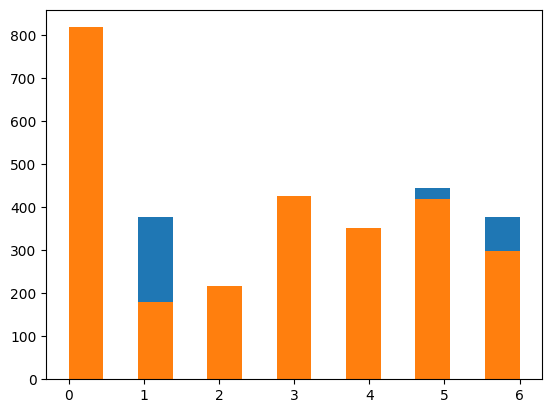

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_mutual_info_score as ari
from sklearn.metrics import accuracy_score as acc
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

f_edge = './data/cora.cites' # file location of the columns
f_nodes = './data/cora.content' # file location of the rows

# display function
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(7):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_



C = 7 # nitiate desired kmeans cluster number
V = 1433 # initiate vocabulary number
word_col_names = ["w{}".format(i) for i in range(V)] # creates words column
df_node = pd.read_csv(f_nodes, sep='\t', header=None, names=['paperid']+word_col_names+['label']) # creates the matrix
print(df_node) # displays the matrix

X = df_node[word_col_names].to_numpy() # turns the matrix into a numpy array
pca = PCA(30) # use pca
data = pca.fit_transform(X) # makes the numpy array fit the pca specifications
model = KMeans(n_clusters=C, random_state=None, init='random', n_init = 15, max_iter = 600)  # initiate the cluster with the desired parameters
model.fit(data) # input the new transformed kmeans into the kmeans model
print(model.labels_[:20]) # prints model label
yhats = model.labels_
np.unique(yhats) # list of the classes
yhats
print(plt.hist(yhats, bins='auto')) # prints the chart

y, y_idx = pd.factorize(df_node['label']) # factorize the df_nodes
labels_encoded, _ = encode_label(df_node['label'])
y_mapping = {y_idx[k]: k for k in range(7)} # matching the index with the array count
print(plt.hist(y, bins='auto')) # hart y chart post factorzation
np.bincount(model.labels_[y==0]) # shows the number of Docs for each cluser label
print(np.bincount(yhats[y==0])/np.bincount(yhats)) # true yhats over total yhats

from sklearn.preprocessing import normalize # increase the accuracy by using normalize
v = np.bincount(yhats[y==0])/np.bincount(yhats)
normalized_v = normalize(v[:,np.newaxis], axis=0).ravel()
hungarian = [] # hungarian algorithm finds mapping between cluster numbers and gtlabels using linear_sum_assignment
for k in range(7):
    hungarian.append(np.bincount(yhats[y==k]))
_, hg_mapping = linear_sum_assignment(hungarian, maximize=True)
for k in y_mapping: # conversion ground truth labels
    masked_labels = model.labels_
    best_cls = np.argmax(
        np.bincount(yhats[y == y_mapping[k]]) / np.bincount(yhats)
    )

print("Acc: {}".format(acc([hg_mapping[i] for i in y], yhats))) # printing accuracy
# X_embedded = TSNE(n_components=2, verbose=1, perplexity=40).fit_transform(X)
X_embedded = TSNE(n_components=2).fit_transform(X)
plot_tSNE(labels_encoded, X_embedded)

Acc = 

<img src="./kmeans.png" alt="示例图片" width="500">